In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image

from sklearn.model_selection import train_test_split

import os
import json
from collections import Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

os.chdir('..')
from configs import path_config, data_config, train_config

from src.visualization import visualize_batch
from src.models import ViT
from src.data import get_dataloader, get_dataset

### Finding the Mean and Standard Deviation of Image Channels

In [2]:
transforms = v2.Compose([
    v2.PILToTensor(),
    v2.Resize((224,224)),
    v2.ToDtype(torch.float32, scale=True),
])

In [3]:
dataset = ImageFolder(root=path_config.dataset_path, transform=transforms)
dataloader = DataLoader(dataset, batch_size=8)

In [25]:
mean = 0
std = 0
n_images = 0

for batch in tqdm(dataloader):
    images, _ = batch
    images = images.view(images.size(0), images.size(1), -1) # [B, C, W*H]
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    n_images += images.size(0)

mean /= n_images
std /= n_images

print(mean)
print(std)

  0%|          | 0/853 [00:00<?, ?it/s]

tensor([0.6053, 0.5874, 0.5538])
tensor([0.2468, 0.2372, 0.2453])


### Testing functions

In [2]:
trainset, valset = get_dataset(train=True)
trainloader = get_dataloader(trainset, True)
valloader = get_dataloader(valset, True)

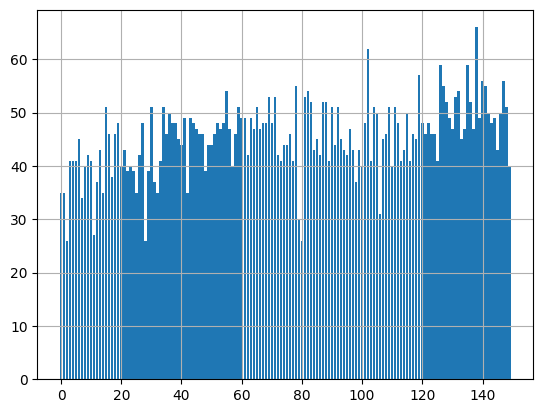

In [3]:
class_dist = Counter(trainset.dataset.targets)
x = np.arange(max(trainset.dataset.targets)+1)
y = [class_dist[c] for c in x]
plt.bar(x, y)
plt.grid()
plt.show()

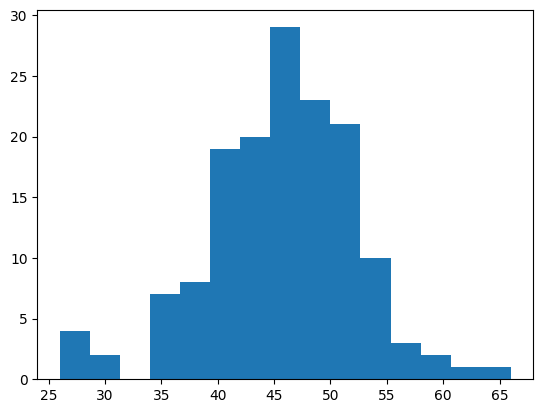

In [4]:
plt.hist(y, bins = 15)
plt.show()

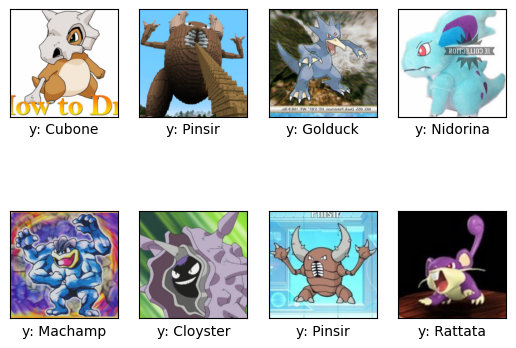

In [5]:
images, labels = next(iter(trainloader))
visualize_batch(images, labels)

In [6]:
patch_size = 16
batch, channels, height, width = images.size()
assert \
    height % patch_size == 0 and width % patch_size == 0, \
    f"Input height ({height}) and width ({width}) must be divisible by patch_size ({patch_size})"


h_patches = height // patch_size # 14
w_patches = width // patch_size # 14

n_patches = h_patches * w_patches

patches = images.unfold(2, patch_size, patch_size)\
    .unfold(3, patch_size, patch_size)\
    .permute(0,2,3,1,4,5)\
    .contiguous()\
    .view(batch, n_patches, -1)
print(patches.size())

torch.Size([8, 196, 768])


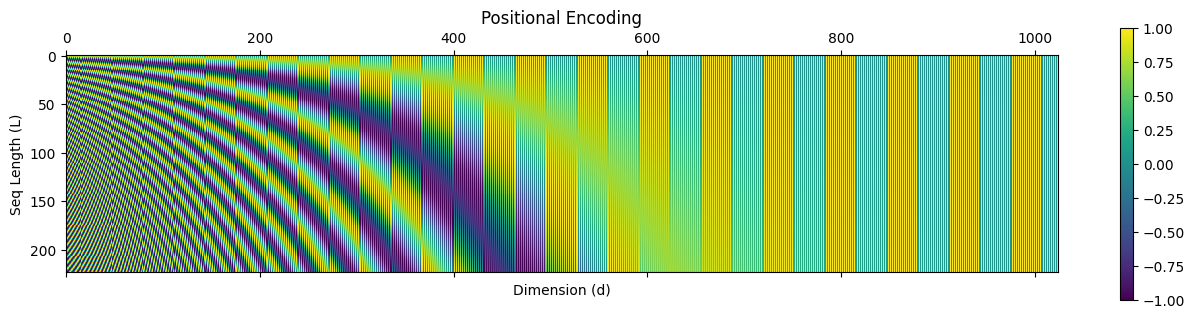

In [7]:
def get_pos_enc(seq_len, d, n=10000):
    """
        seq_len: Length of Sequence (L)
        d: Dimensionality of each Sequence
        n: Scalar
    """
    pe = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in range(d//2):
            denominator = n**(2*i/d)
            pe[k, 2*i] = np.sin(k/denominator)
            pe[k, 2*i+1] = np.cos(k/denominator)
    return torch.Tensor(pe)

cax = plt.matshow(get_pos_enc(14*16, 1024))
plt.gcf().colorbar(cax)
plt.title("Positional Encoding")
plt.xlabel("Dimension (d)")
plt.ylabel("Seq Length (L)")
plt.show()

In [8]:
vit = ViT(data_config, train_config)
print(vit)
print("Output shape:",vit(images).shape)

ViT(
  (embedding): InputEmbeddings(
    (linear_projection): Linear(in_features=768, out_features=512, bias=True)
  )
  (encoders): Sequential(
    (0): Encoder(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention_block): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (mlp_block): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.5, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.5, inplace=False)
      )
    )
    (1): Encoder(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention_block): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (mlp_block): Sequential(
        (0): Linear(in_features=512